In [545]:
import numpy as np
import pandas as pd
import warnings
import os


### Establish connection to the postgres db:

In [546]:
import psycopg2
conn = psycopg2.connect("dbname=bball user=andric")
cur = conn.cursor()

Below two cells provide example for necessary "rollback" when twice a call is made on a bad query.

Postgres gives the `current transaction is aborted, commands ignored until of transaction block`
when this happens

In [21]:

# quer = "select * from playerdata WHERE season='2013';"
#cur.execute(quer)
# quer_out = cur.fetchall()
# pd.DataFrame(quer_out)

InternalError: current transaction is aborted, commands ignored until end of transaction block


In [24]:
# conn.rollback()

### This query grabs the column names from the db table

In [547]:
quer = "select column_name from information_schema.columns \
where table_schema = 'public' and table_name = 'playerdata';"
cur.execute(quer)
quer_out = cur.fetchall()
headers = [hh[0] for hh in quer_out]

### Now query to grab data.

In [43]:
# quer = "select * from playerdata where season='2013';"
# cur.execute(quer)
# data_quer_out = cur.fetchall()
# pd.DataFrame(data_quer_out).shape
# df13 = pd.DataFrame(data_quer_out, columns=headers).iloc[:, 1:]

(452, 29)

In [548]:
def get_season_data(year):
    """Get dataframe from query.
    Build list of them.
    """
    quer = "select * from playerdata where season='%s';" % year
    cur.execute(quer)
    data_quer_out = cur.fetchall()
    return data_quer_out


df_list = []
for yr in range(2012, 2017):
    df_list.append(pd.DataFrame(
            get_season_data(yr), columns=headers).iloc[:, 1:])

In [549]:
df12, df13, df14, df15, df16 = df_list
players_intersect = list(set(df16.player).intersection(
        df15.player).intersection(
        df14.player).intersection(
        df13.player).intersection(
        df12.player))

#### get players common to all four data frames:

In [550]:
def keepers(dataframe, player_list):
    return dataframe.iloc[np.where(np.in1d(dataframe.player,
                                           player_list)==True)[0], :]

In [551]:
keepers_df_list = []
for df in df_list:
    keepers_df_list.append(
        keepers(df, players_intersect).sort_values('player'))

df12, df13, df14, df15, df16 = keepers_df_list

#### Now tables are sorted with same players.

### Build some models

In [172]:
from sklearn.linear_model import LinearRegression

In [552]:
df12.columns

Index(['player', 'season', 'age', 'g', 'gs', 'mp', 'fg', 'fga', 'fgp', '3p',
       '3pa', '3pp', '2p', '2pa', '2pp', 'efgp', 'ft', 'fta', 'ftp', 'orb',
       'drb', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'psg'],
      dtype='object')

In [554]:
X = np.column_stack([df15.fgp.values, df14.fgp.values, df13.fgp.values, df12.fgp.values])
y = df16.psg.values
linr = LinearRegression()
linr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [555]:
print('Explain PS/G:')
for n in np.argsort(linr.coef_)[::-1]:
    print('%.4f' % linr.coef_[n])


Explain PS/G:
8.6749
5.7504
3.6684
-1.8555


In [556]:
print([i for i, pp in enumerate(df16.player) if pp == 'LeBron James'])
print([i for i, pp in enumerate(df16.player) if pp == 'Patrick Beverley'])
print([i for i, pp in enumerate(df16.player) if pp == 'Timofey Mozgov'])
print([i for i, pp in enumerate(df16.player) if pp == 'Kevin Durant'])
print([i for i, pp in enumerate(df16.player) if pp == 'Kemba Walker'])

[142]
[]
[213]
[125]
[122]


In [557]:
print('LeBron: %.4f' % linr.predict(df16.iloc[
            [i for i, pp in enumerate(df16.player) if pp == 'LeBron James'], :][
            ['fgp', 'ftp', 'efgp', 'psg']].values.reshape(1, -1)))
print('Mozgov: %.4f' % linr.predict(df16.iloc[233, :][['fgp', 'ftp', 'efgp', 'psg']].values.reshape(1, -1)))
print('Durant: %.4f' % linr.predict(df16.iloc[136, :][['fgp', 'ftp', 'efgp', 'psg']].values.reshape(1, -1)))
print('Kemba: %.4f' % linr.predict(df16.iloc[131, :][['fgp', 'ftp', 'efgp', 'psg']].values.reshape(1, -1)))

LeBron: -12.7066


IndexError: single positional indexer is out-of-bounds

## Plot features

In [260]:
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [553]:
#sns.pairplot(df13.iloc[:, 3:])

In [272]:
df13.columns[3:]

Index(['g', 'gs', 'mp', 'fg', 'fga', 'fgp', '3p', '3pa', '3pp', '2p', '2pa',
       '2pp', 'efgp', 'ft', 'fta', 'ftp', 'orb', 'drb', 'trb', 'ast', 'stl',
       'blk', 'tov', 'pf', 'psg'],
      dtype='object')

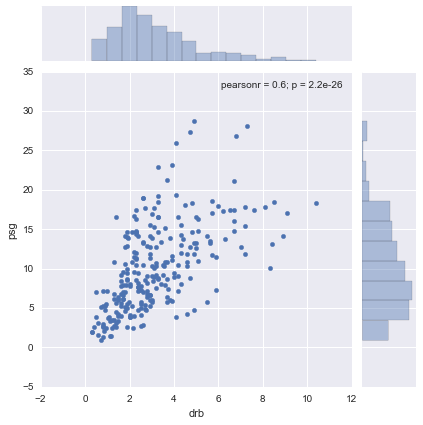

In [281]:
sns.jointplot(x='drb', y='psg', data=df13)

In [292]:
df13.corr()

,age,g,gs,mp,fg,fga,fgp,3p,3pa,3pp,...,ftp,orb,drb,trb,ast,stl,blk,tov,pf,psg
age,1.000000,0.078156,0.005800,0.126351,0.127004,0.116413,0.075614,0.109731,0.096380,0.033425,...,0.110271,-0.028533,0.125699,0.079138,0.134390,0.050330,0.006467,-0.058074,0.067308,0.132826
g,0.078156,1.000000,0.557615,0.547672,0.448260,0.433312,0.195372,0.235207,0.214456,0.064143,...,0.186020,0.169698,0.335902,0.297360,0.254690,0.389778,0.216665,-0.045554,0.405771,0.438481
gs,0.005800,0.557615,1.000000,0.797097,0.708528,0.676498,0.154048,0.195833,0.195345,-0.041606,...,0.080287,0.367031,0.620843,0.567907,0.465193,0.586945,0.380663,0.019063,0.548520,0.676559
mp,0.126351,0.547672,0.797097,1.000000,0.892895,0.900741,0.276208,0.426810,0.446897,0.138325,...,0.287296,0.320405,0.665505,0.584542,0.664637,0.735352,0.294488,-0.026540,0.609044,0.889072
fg,0.127004,0.448260,0.708528,0.892895,1.000000,0.974563,0.287264,0.359400,0.380600,0.107358,...,0.254002,0.325032,0.659277,0.581476,0.592068,0.639856,0.327159,0.003950,0.512027,0.982362
fga,0.116413,0.433312,0.676498,0.900741,0.974563,1.000000,0.264560,0.479190,0.513165,0.178932,...,0.324205,0.217795,0.583589,0.490215,0.646001,0.670922,0.215529,0.008232,0.465887,0.978008
fgp,0.075614,0.195372,0.154048,0.276208,0.287264,0.264560,1.000000,0.110498,0.115815,0.306649,...,0.797729,0.068871,0.221130,0.182145,0.203408,0.256247,0.083600,-0.021508,0.163503,0.274171
3p,0.109731,0.235207,0.195833,0.426810,0.359400,0.479190,0.110498,1.000000,0.985765,0.544287,...,0.428786,-0.465047,-0.107649,-0.240548,0.458836,0.411885,-0.322619,-0.044852,-0.008684,0.465224
3pa,0.096380,0.214456,0.195345,0.446897,0.380600,0.513165,0.115815,0.985765,1.000000,0.534482,...,0.438153,-0.466576,-0.095682,-0.232209,0.487123,0.441358,-0.337552,-0.037674,-0.010009,0.487208
3pp,0.033425,0.064143,-0.041606,0.138325,0.107358,0.178932,0.306649,0.544287,0.534482,1.000000,...,0.488647,-0.428105,-0.193876,-0.287967,0.264966,0.211914,-0.190705,-0.045789,-0.164089,0.167143


In [310]:
df13.corr()['psg'][np.argsort(df13.corr()['psg'])][::-1][2:8]

fga    0.978008
2pa    0.889459
mp     0.889072
ft     0.883858
2p     0.876684
fta    0.864628
Name: psg, dtype: float64

In [305]:
df14.corr()['psg'][np.argsort(df14.corr()['psg'])][::-1][2:8]

fga    0.976806
ft     0.896381
fta    0.877399
2pa    0.874737
mp     0.873380
2p     0.867874
Name: psg, dtype: float64

In [309]:
df15.corr()['psg'][np.argsort(df15.corr()['psg'])][::-1][2:8]

fga    0.978631
ft     0.896732
2pa    0.879672
fta    0.873322
2p     0.868294
mp     0.867916
Name: psg, dtype: float64

In [400]:
X = np.column_stack([df15.fga, df15.ft, df15.loc[:, "2pa"], df15.mp])
y = df15.psg.values
linr = LinearRegression()
linr.fit(X, y)
print('Explain PS/G:')
for n in np.argsort(linr.coef_)[::-1]:
    print('%.4f' % linr.coef_[n])


Explain PS/G:
1.0711
0.9363
0.0498
-0.0643


In [329]:
print('LeBron: %.4f' % linr.predict(df16.iloc[154, :][['fga', 'ft', '2pa']].values.reshape(1, -1)))
print('Kemba: %.4f' % linr.predict(df16.iloc[131, :][['fga', 'ft', '2pa']].values.reshape(1, -1)))
print('Mozgov: %.4f' % linr.predict(df16.iloc[233, :][['fga', 'ft', '2pa']].values.reshape(1, -1)))

LeBron: 23.0726
Kemba: 21.0353
Mozgov: 5.5556


In [372]:
from sklearn.cross_validation import train_test_split

In [595]:
X = np.column_stack([df15.psg, df14.psg, df13.psg, df12.psg, pd.stats.moments.ewma(df16.psg, com=1)])
# X = np.column_stack([df15.psg, df14.psg, df13.psg, df12.psg])
y = df16.psg
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [596]:
X = np.column_stack([df15.psg, df14.psg, df13.psg, df12.psg, pd.stats.moments.ewma(df16.psg, com=1)])
# X = np.column_stack([df15.psg, df14.psg, df13.psg, df12.psg])
y = df16.psg
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
linr = LinearRegression()
linr.fit(X_train, y_train)
y_train_pred = linr.predict(X_train)
y_test_pred = linr.predict(X_test)

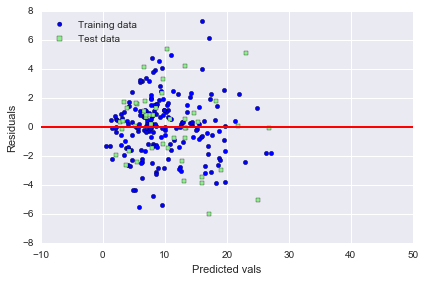

In [597]:
plt.scatter(y_train_pred, y_train_pred - y_train, c='blue', marker='o', label='Training data')
plt.scatter(y_test_pred, y_test_pred - y_test, c='lightgreen', marker='s', label='Test data')
plt.xlabel('Predicted vals')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])

plt.tight_layout()
plt.show()

In [593]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [598]:
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test %.3f' % (
        r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

MSE train: 4.287, test: 5.798
R^2 train: 0.871, test 0.878


In [404]:
# [df15.fga, df15.ft, df15.loc[:, "2pa"]]
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test %.3f' % (
        r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

MSE train: 0.693, test: 0.485
R^2 train: 0.978, test 0.980


In [408]:
# [df15.fga, df15.ft]
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test %.3f' % (
        r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

MSE train: 0.616, test: 0.879
R^2 train: 0.979, test 0.972


#### multi-year psg

In [441]:
psg_stack = np.column_stack([df13.psg.values, df14.psg.values, df15.psg.values])
# pd.stats.moments.ewma(np.column_stack([df13.psg.values, df14.psg.values, df15.psg.values]), com=1)
#help(pd.stats.moments.ewma)

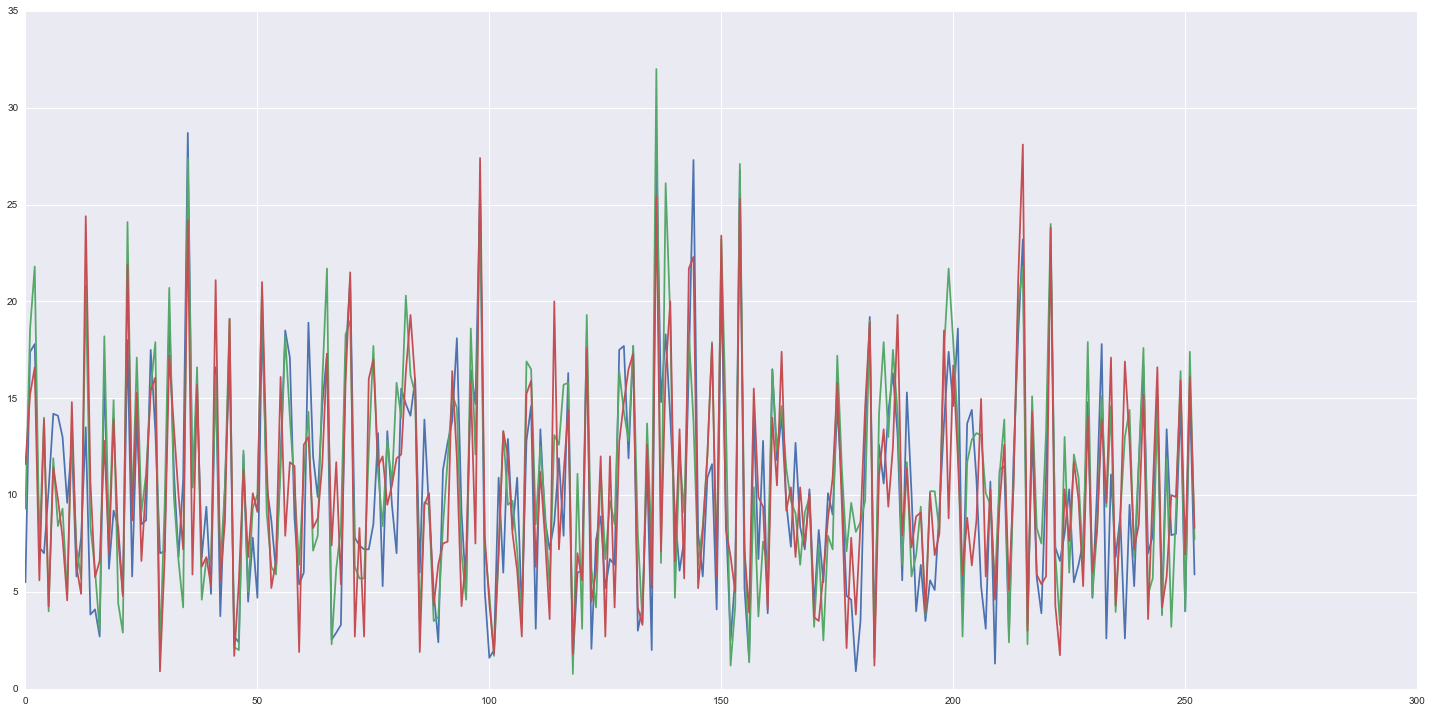

In [468]:
pd.stats.moments.ewma(psg_stack, com=1)
#psg_stack
plt.figure(figsize=(20, 10))
plt.plot(range(253), psg_stack)
plt.tight_layout()
plt.show()

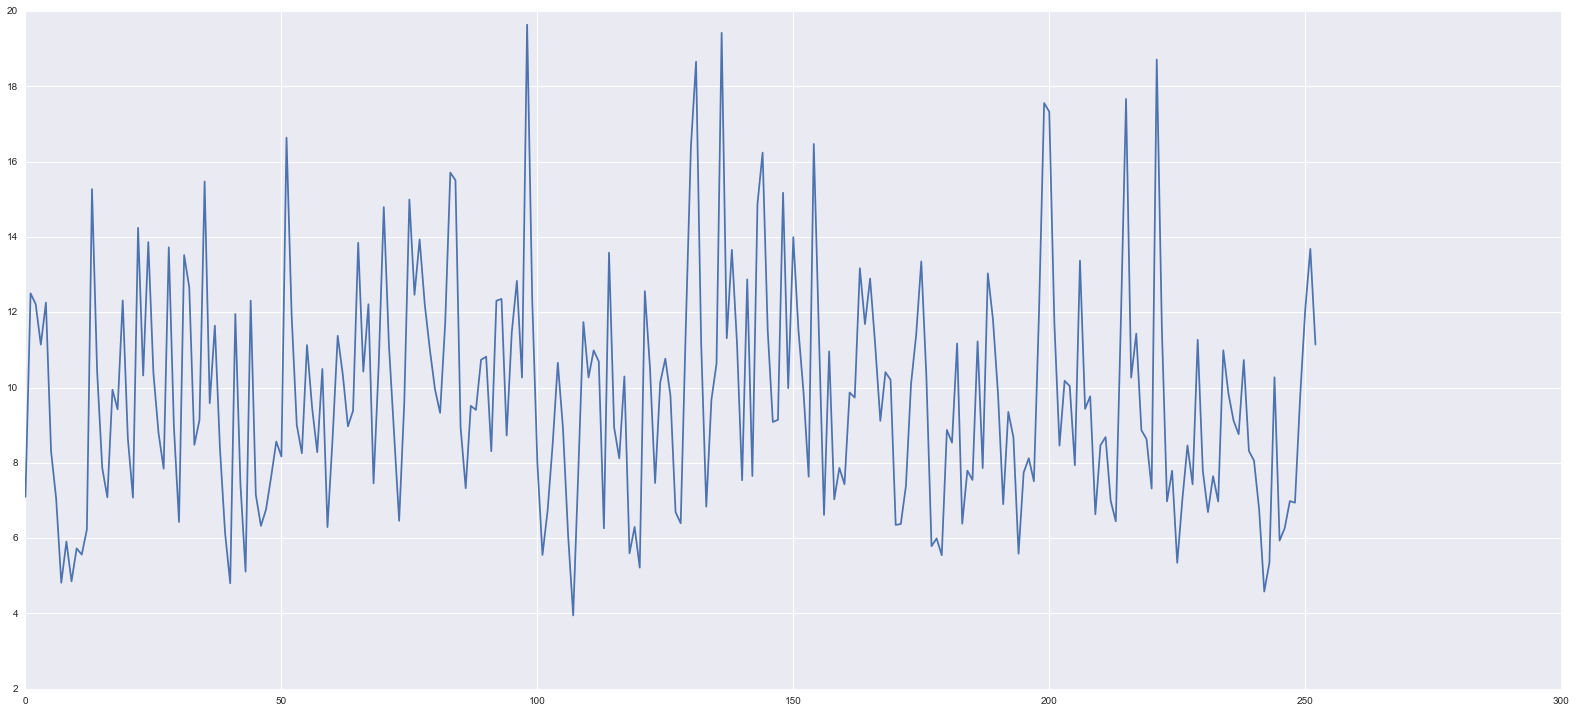

In [485]:
#pd.stats.moments.ewma(psg_stack, com=1)
#psg_stack
plt.figure(figsize=(22, 10))
# plt.plot(range(253), pd.stats.moments.ewma(psg_stack, com=2))
plt.plot(range(253), pd.stats.moments.ewma(df16.psg.values, com=1))
plt.tight_layout()
plt.show()

In [509]:
print(pd.Series(df16.psg.values).describe())
print(pd.Series(pd.stats.moments.ewma(df16.psg.values, com=2)).describe())

count    253.000000
mean       9.798885
std        5.796649
min        0.900000
25%        5.600000
50%        8.500000
75%       12.800000
max       30.100000
dtype: float64
count    253.000000
mean       9.788760
std        2.210143
min        5.345936
25%        8.061989
50%        9.723414
75%       11.239476
max       16.767951
dtype: float64


In [536]:
# np.vstack((psg_stack, pd.stats.moments.ewma(df16.psg.values, com=2)[np.newaxis, :]))
print(psg_stack.shape)
# emov_n = pd.stats.moments.ewma(df16.psg.values, com=2)
print(emov_n[:, np.newaxis].shape)

(253, 3)
(253, 1)


In [540]:
Xs = np.hstack((psg_stack, emov_n[:, np.newaxis]))

In [541]:
clf = LinearRegression()
clf.fit(Xs, df16.psg.values)
print(clf.coef_)

[-0.10961216  0.13005609  0.60190105  1.01814924]


In [543]:
df14.psg.values[154], df16.psg.values[154], df16.psg.values[154] 

(27.100000000000001, 25.300000000000001, 25.300000000000001)

In [544]:
cur.close()
conn.close()

In [599]:
from sklearn.ensemble import RandomForestRegressor

In [701]:
indx = np.where(df16.columns == 'ast')[0]
X = np.column_stack([df12.iloc[:, indx], df13.iloc[:, indx], df14.iloc[:, indx], 
                     df15.iloc[:, indx], pd.stats.moments.ewma(df16.iloc[:, indx], com=1)])
X = np.column_stack([df12.psg, df13.psg, df14.psg, df15.psg, pd.stats.moments.ewma(df16.iloc[:, indx], com=1)])
# X = np.column_stack([df15.psg, df14.psg, df13.psg, df12.psg])
y = df16.psg
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1)

forest = RandomForestRegressor(n_estimators=1000, criterion='mse', random_state=1, n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test %.3f' % (
        r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

MSE train: 1.221, test: 8.233
R^2 train: 0.964, test 0.847


In [702]:
linr = LinearRegression()
linr.fit(X_train, y_train)
y_train_pred = linr.predict(X_train)
y_test_pred = linr.predict(X_test)
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test %.3f' % (
        r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

MSE train: 7.275, test: 6.186
R^2 train: 0.787, test 0.885


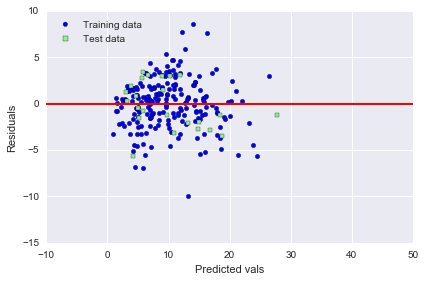

In [703]:
plt.scatter(y_train_pred, y_train_pred - y_train, c='blue', marker='o', label='Training data')
plt.scatter(y_test_pred, y_test_pred - y_test, c='lightgreen', marker='s', label='Test data')
plt.xlabel('Predicted vals')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])

plt.tight_layout()
plt.show()

In [723]:
player='Chris Paul'
indx = np.where(df16.columns == 'ast')[0]
print('linear pred: %.4f' % linr.predict(np.column_stack((df12.iloc[:, indx].values[np.where(df12.player==player)],
df13.iloc[:, indx].values[np.where(df12.player==player)], 
df14.iloc[:, indx].values[np.where(df12.player==player)], 
df15.iloc[:, indx].values[np.where(df12.player==player)], 
pd.stats.moments.ewma(df16.iloc[:, indx], com=1).values[np.where(df12.player==player)]))))
print('forest pred: %.4f' % forest.predict(np.column_stack((df12.iloc[:, indx].values[np.where(df12.player==player)],
df13.iloc[:, indx].values[np.where(df12.player==player)], 
df14.iloc[:, indx].values[np.where(df12.player==player)], 
df15.iloc[:, indx].values[np.where(df12.player==player)], 
pd.stats.moments.ewma(df16.iloc[:, indx], com=1).values[np.where(df12.player==player)]))))


linear pred: 13.5662
forest pred: 10.2165
